In [1]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

from keras import layers

from keras.applications import VGG16
from keras.applications import MobileNet 
from keras.applications import ResNet50
from keras.applications import InceptionV3
from keras.applications import Xception
from keras.applications import EfficientNetB0


#from datasets import load_dataset

import pathlib


2025-05-06 14:34:41.415480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746513281.474231    1328 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746513281.490291    1328 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746513281.622734    1328 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746513281.622752    1328 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746513281.622752    1328 computation_placer.cc:177] computation placer alr

In [2]:

# List all available GPU devices
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        # Enable memory growth for each GPU
        # This prevents TensorFlow from allocating all GPU memory at once
        # Instead, it allocates memory dynamically as needed
        tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# # Load the dataset from Hugging Face
# dataset = load_dataset("Rekzi/cat-breeds", cache_dir="cat_breeds")
# print("Dataset splits:", dataset.keys())

In [4]:
data_dir = "./dataset"
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('dataset')

In [5]:
img_width = 224
img_height = 224
batch_size = 32

In [6]:
split = 0.2
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,                       # Main directory containing all class folders
    validation_split=split,           # 20% for validation
    subset="training",              # Specify we want the training subset
    seed=123,                       # For reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Check the class names that were found
class_names = train_ds.class_names
print(class_names)

Found 28000 files belonging to 5 classes.
Using 22400 files for training.


I0000 00:00:1746514474.960445    1328 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 28000 files belonging to 5 classes.
Using 5600 files for validation.
['drawings', 'hentai', 'neutral', 'porn', 'sexy']


In [34]:
# #WE DONT NEED TO SHOW THIS
# plt.figure(figsize=(10, 10))
# unique = []
# for images, labels in train_ds.take(1):
#   for i in range(len(images)):
#     if(class_names[labels[i]] in unique):
#       continue
#     ax = plt.subplot(1, 6, len(unique) + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")
#     unique.append(class_names[labels[i]])

In [7]:
# Collect labels from training dataset
train_labels = []
for _, y in train_ds:
    train_labels.extend(y.numpy())

# Collect labels from validation dataset
val_labels = []
for _, y in val_ds:
    val_labels.extend(y.numpy())

# Combine and analyze labels
all_train_labels = np.array(train_labels)
all_val_labels = np.array(val_labels)

2025-05-06 14:54:44.933125: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-06 14:54:46.192346: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


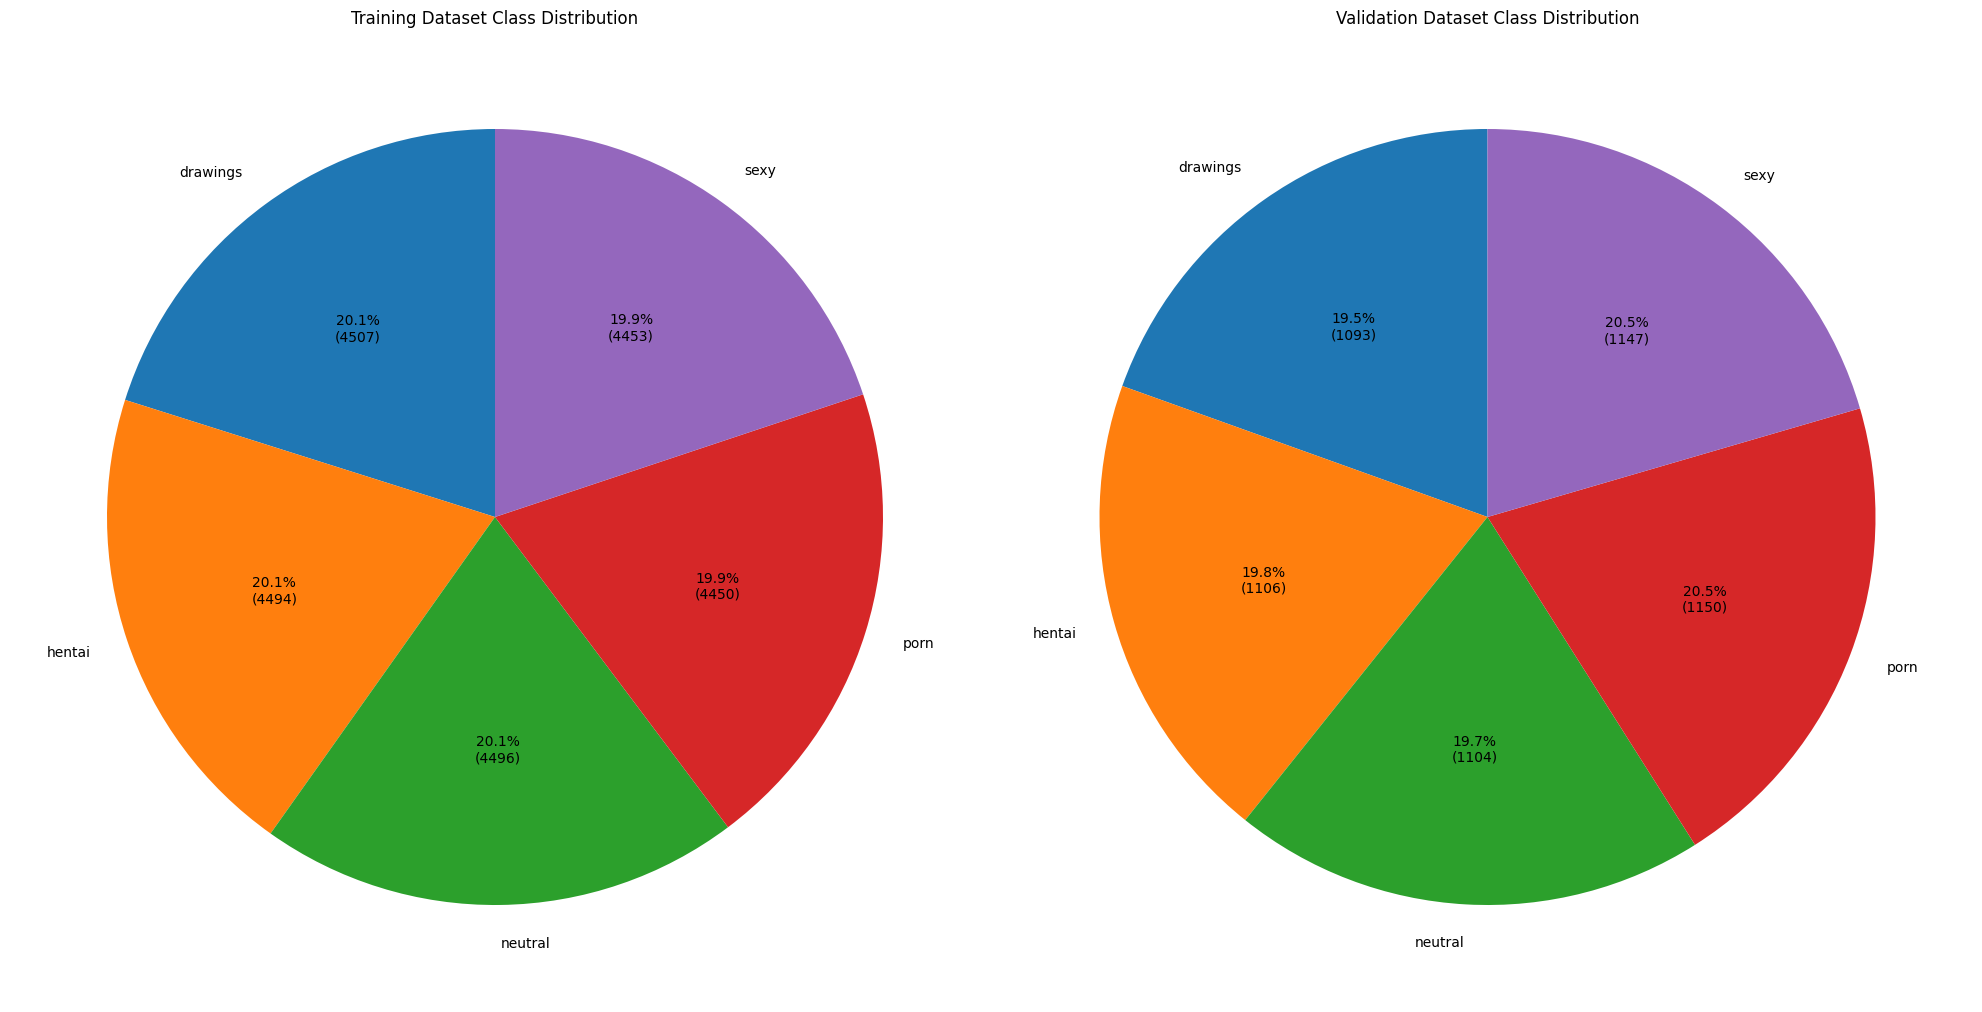

In [8]:
# Count occurrences in training dataset
train_unique_classes, train_counts = np.unique(all_train_labels, return_counts=True)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%\n({val:d})'
    return my_autopct

plt.pie(train_counts, 
        labels=[class_names[i] for i in train_unique_classes], 
        autopct=make_autopct(train_counts),
        startangle=90)
plt.title('Training Dataset Class Distribution')

# Count occurrences in validation dataset
val_unique_classes, val_counts = np.unique(all_val_labels, return_counts=True)

# Subplot for validation dataset
plt.subplot(1, 2, 2)
plt.pie(val_counts, 
        labels=[class_names[i] for i in val_unique_classes], 
        autopct=make_autopct(val_counts),
        startangle=90)
plt.title('Validation Dataset Class Distribution')

plt.tight_layout()
plt.show()

In [62]:
def create_model(pre_trained_model):
    pre_trained_model.trainable = False

    # for layer in pre_trained_model.layers[:-3]:
    #     layer.trainable = True

    augment = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ], name="augmentation_layers")
    
    model = tf.keras.Sequential([
        layers.Rescaling(1.0 / 255, input_shape=(img_width, img_height, 3)),
        # augment,
        pre_trained_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(len(train_unique_classes), activation="softmax")
    ])
    return model

In [63]:
pre = MobileNet(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))

model2 = create_model(pre)

model2.compile(
    optimizer="adam",
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model2.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,233,989 (12.34 MB)

 Trainable params: 5,125 (20.02 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [64]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model2.fit(
    train_ds,
    steps_per_epoch=len(train_ds),
    validation_data=val_ds,
    validation_steps=len(val_ds),
    epochs=100,
    callbacks=[
        early_stopping,
    ]
)

Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.7234 - loss: 0.7144 - val_accuracy: 0.8345 - val_loss: 0.4239
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8535 - loss: 0.3853 - val_accuracy: 0.8545 - val_loss: 0.3819
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.8654 - loss: 0.3549 - val_accuracy: 0.8550 - val_loss: 0.3742
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.8746 - loss: 0.3276 - val_accuracy: 0.8582 - val_loss: 0.3698
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.8792 - loss: 0.3137 - val_accuracy: 0.8459 - val_loss: 0.3948
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.8890 - loss: 0.3029 - val_accuracy: 0.8616 - val_loss: 0.3713
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.8897 - loss: 0.2971 - val_accuracy: 0.8546 - val_loss: 0.3752


In [65]:
model2.evaluate(val_ds)

175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8520 - loss: 0.3731


[0.37515750527381897, 0.8546428680419922]

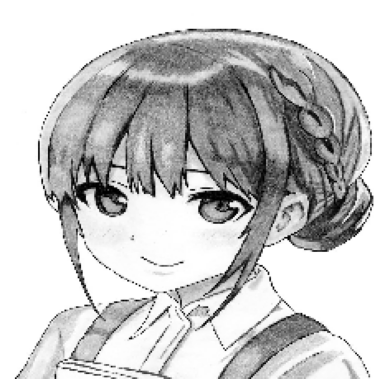

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
drawings: 0.6542
hentai: 0.1708
neutral: 0.1750
porn: 0.0000
sexy: 0.0000
Predicted class: drawings
Confidence: 0.65418506


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

img_path = './real/neutral/1.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension
# No need to normalize here if Rescaling layer is in the model

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Get prediction
predictions = model2.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class_name = class_names[predicted_class_index]

# Show all class probabilities
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {predictions[0][i]:.4f}")

print("Predicted class:", predicted_class_name)
print("Confidence:", predictions[0][predicted_class_index])

In [26]:
# for images, labels in val_ds.take(1):
#     first_batch_predictions = model2.predict(images)
#     first_batch_predicted_labels = np.argmax(first_batch_predictions, axis=1)
#     first_batch_true_labels = labels.numpy()
#     # print("\nPredictions on the first batch:", first_batch_predicted_labels)
#     # print("True labels of the first batch:", first_batch_true_labels)
#     plt.figure(figsize=(15, 10))
#     for i in range(len(images)):
#         true_label = class_names[labels[i].numpy()]
#         plt.subplot(2, 2, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         predicted_label = class_names[first_batch_predicted_labels[i]]
#         title_color = "green" if true_label == predicted_label else "red"
#         plt.title(f"True: {true_label}\nPred: {predicted_label}", color=title_color, fontsize=10)
#         plt.axis("off")
#     plt.tight_layout()
#     plt.show()

In [21]:
import pickle

with open("class_indices.pkl", "wb") as f:
    pickle.dump({"Drawing": 0, "Hentai": 1, "Neutral" : 2, "Porn": 3, "Sexy" : 4}, f)

with open("class_indices.pkl", "rb") as f:
    pick = pickle.load(f)
    print(pick)

model2.save('nsfw.h5')

{'Drawing': 0, 'Hentai': 1, 'Neutral': 2, 'Porn': 3, 'Sexy': 4}
